<a href="https://colab.research.google.com/github/mark-morelos/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
# train/test split
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# creating new column running to_datetime func
df['created_date'] = pd.to_datetime(df['created'])
type(df['created_date'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [24]:
# checking the dtype ensuring datetime type
df['created_date'].sort_values()

5186    2016-04-01 22:12:41
7945    2016-04-01 22:56:00
6424    2016-04-01 22:57:15
7719    2016-04-01 23:26:07
1723    2016-04-02 00:48:13
                ...        
19943   2016-06-29 17:47:34
16801   2016-06-29 17:56:12
32633   2016-06-29 18:14:48
20560   2016-06-29 18:30:41
17743   2016-06-29 21:41:47
Name: created_date, Length: 48817, dtype: datetime64[ns]

In [26]:
# work with the date to extract the year only
df['created_month'] = df['created_date'].dt.month
df[['created_date', 'created_month']].sample(4)

,created_date,created_month
21195,2016-06-26 03:05:58,6
35058,2016-05-03 02:25:49,5
30866,2016-05-05 02:22:45,5
39739,2016-05-23 05:26:35,5


In [72]:
# splitting train & test: train for apr & may (<6), test for june (>=6)
train = df[df['created_month']<6]
test = df[df['created_month']>=6]

train.shape, test.shape

((31844, 39), (16973, 39))

In [70]:
# feature based on interest_level, converting categorical to numerical

df['int_level'] = df['interest_level'].map({'low':1,
                                            'medium':2,
                                            'high':3})
df['int_level'].value_counts()

1    33946
2    11181
3     3690
Name: int_level, dtype: int64

In [71]:
# additional feature dogs & cats
df['pets'] =  df['cats_allowed'] + df['dogs_allowed']
df['pets_allowed'] = df['pets'].map({2:1,
                                     1:1,
                                     0:0})
df['pets_allowed'].value_counts()


0    25433
1    23384
Name: pets_allowed, dtype: int64

In [33]:
# check dataframe
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,created_date,created_month,int_level,pets,pets_allowed
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-24 07:54:24,6,2,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-06-12 12:19:27,6,1,2,1
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-17 03:26:41,4,3,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-18 02:22:02,4,1,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016-04-28 01:32:41,4,1,0,0


In [44]:
# begin with baseline
train['price'].mean()

3575.604007034292

In [73]:
# arrange y target vectors
target = 'price'
y_train = train[target]
y_test = test[target]
y_train.shape, y_test.shape

((31844,), (16973,))

In [74]:
# mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()
guess

Mean Baseline (using 0 features)


3575.604007034292

In [77]:
# train error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
y_pred
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (Apr-May Apt Cost): {mae:.2f}')

Train Error (Apr-May Apt Cost): 1201.88


In [53]:
# test error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (Jun Apt Cost): {mae:.2f} percentage points')

Test Error(Jun Apartment Cost): 1197.71


In [78]:
import pandas as pd
import plotly.express as px

px.scatter(
    train,
    x='int_level',
    y='price',
    text='created_month',
    title='NYC Apt Cost Apr-Jun',
    trendline='ols'
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [79]:
# one feature
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

In [80]:
# 2. Instantiate this class
model = LinearRegression()

In [81]:
# 3. Arrange X features matrices (already did y target vectors)
features = ['int_level']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')
X_train.shape, X_test.shape

Linear Regression, dependent on: ['int_level']


((31844, 1), (16973, 1))

In [82]:
# 4. Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f}')

Train Error: 1178.10


In [83]:
# 5. Apply the model to new data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f}')

Test Error: 1173.72


In [64]:
# multiple regression using the 2 created features (int_level & pets_allowed)

import plotly.express as px
px.scatter_3d(
    train,
    x='int_level',
    y='pets_allowed',
    z='price',
    text='created_month',
    title='Apartment Cost in NYC'
)

In [84]:
# using scikit-learn to fit multiple regression with two features
features = ['int_level', 
            'pets_allowed']
print(f'Linear Regression, dependent on: {features}')

X_train = train[features]
X_test = test[features]
X_train.shape, X_test.shape


Linear Regression, dependent on: ['int_level', 'pets_allowed']


((31844, 2), (16973, 2))

In [85]:
# fit the model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [86]:
# apply the model to new data
y_pred = model.predict(X_train)
y_pred

mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} percentage points')

Train Error: 1176.17 percentage points


In [87]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f}')

Test Error: 1172.13


In [88]:
# getting the model's coefficient and intercepts
model.intercept_, model.coef_

(4287.302303416773, array([-563.72687665,  142.34275693]))

In [89]:
beta0 = model.intercept_
beta1, beta2 = model.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 4287.302303416773 + -563.7268766521181x1 + 142.34275692572925x2


In [90]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, features)
print(coefficients.to_string())

Intercept 4287.302303416773
int_level      -563.726877
pets_allowed    142.342757


In [91]:
# visualizing squared errors
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
   
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)

    x = df[feature]
    y = df[target]
    y_pred = m*x + b

    ax.plot(x, y_pred)
    
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 3105028.217891242
Root Mean Squared Error: 1762.1090255404863
Mean Absolute Error: 1201.8811133682555
R^2: 0.0


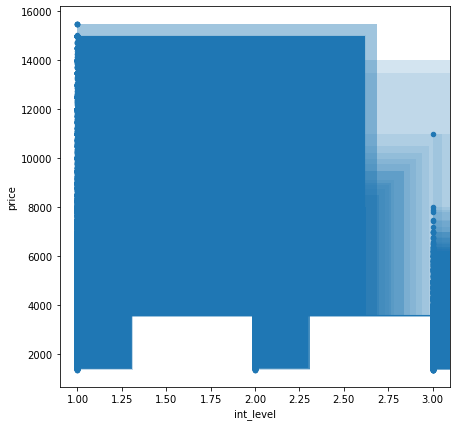

In [92]:
feature = 'int_level'
squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 15542239.708673533
Root Mean Squared Error: 3942.364735621697
Mean Absolute Error: 3526.4545597286774
R^2: -4.005506751635558


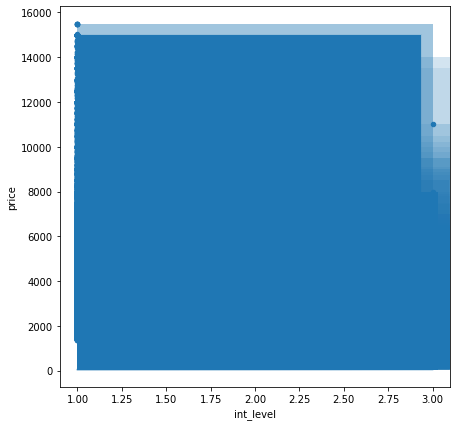

In [96]:
squared_errors(train, feature, target, m=3, b=45)

Mean Squared Error: 3108152.385651076
Root Mean Squared Error: 1762.9952880399528
Mean Absolute Error: 1197.7088871089013
R^2: -4.218690517676649e-05


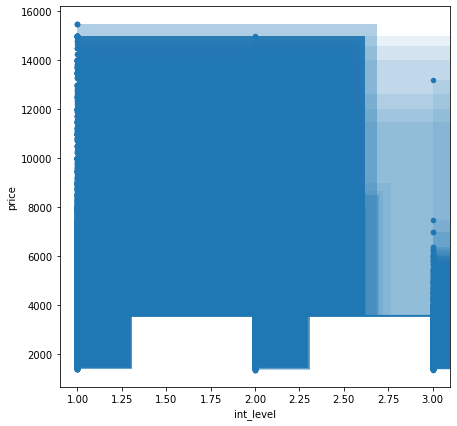

In [97]:
feature = 'int_level'
squared_errors(test, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 15626339.83179167
Root Mean Squared Error: 3953.0165483832307
Mean Absolute Error: 3537.9305367348143
R^2: -4.027745464106313


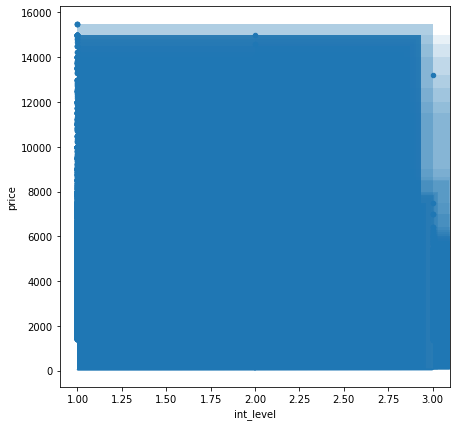

In [98]:
squared_errors(test, feature, target, m=3, b=45)

Mean Squared Error: 3105028.217891242
Root Mean Squared Error: 1762.1090255404863
Mean Absolute Error: 1201.8811133682555
R^2: 0.0


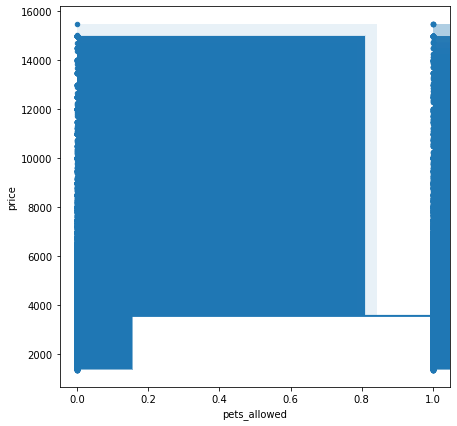

In [99]:
feature = 'pets_allowed'
squared_errors(train, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 15559802.369268935
Root Mean Squared Error: 3944.591533894091
Mean Absolute Error: 3529.170424569778
R^2: -4.011162951632133


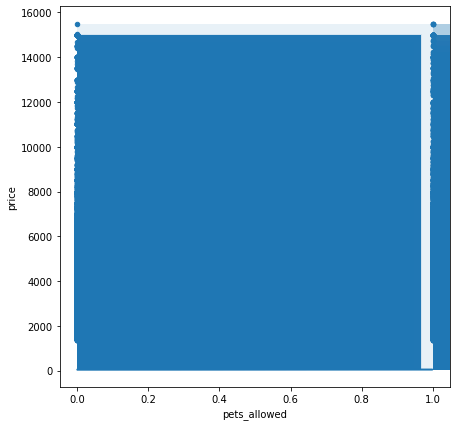

In [100]:
squared_errors(train, feature, target, m=3, b=45)

Mean Squared Error: 3108152.385651076
Root Mean Squared Error: 1762.9952880399528
Mean Absolute Error: 1197.7088871089013
R^2: -4.218690517676649e-05


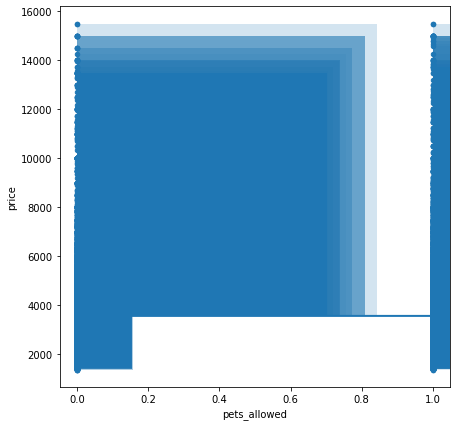

In [101]:
squared_errors(test, feature, target, m=0, b=y_train.mean())

Mean Squared Error: 15643686.528545337
Root Mean Squared Error: 3955.210048599864
Mean Absolute Error: 3540.611147116008
R^2: -4.033326731175843


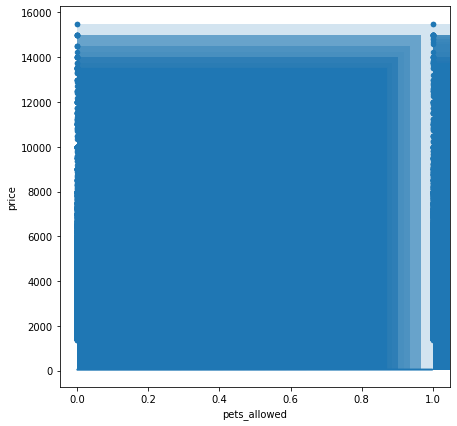

In [102]:
squared_errors(test, feature, target, m=3, b=45)